# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Smoothing" data-toc-modified-id="Smoothing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Smoothing</a></div><div class="lev2 toc-item"><a href="#Small-sigma" data-toc-modified-id="Small-sigma-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Small sigma</a></div><div class="lev1 toc-item"><a href="#Bigger-sigma" data-toc-modified-id="Bigger-sigma-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bigger sigma</a></div>

In [1]:
import os
os.chdir('../../')
from spikelearn.data.preprocessing import kernel_smooth
from spikelearn.data import io, SHORTCUTS
from spikelearn.data.selection import select, to_feature_array
import pandas as pd

BASELINE = -500
DSET_PARAMS = {'wide_smoothed' : { 'sigma' : 100,
                                  'bin_size' : 100},

              'narrow_smoothed' : { 'sigma' : 50,
                                    'bin_size' : 100},

              'wide_smoothed_viz' : { 'sigma' : 100,
                                      'bin_size' : 20},

              'narrow_smoothed_viz' : { 'sigma' : 50,
                                        'bin_size' : 20}
                }


In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [4]:
epoch = io.load('DRRD 8', 'epoched_spikes')

In [12]:
np.histogram(epoch.loc[(1,0),'time'])

(array([1, 1, 2, 0, 1, 5, 0, 2, 3, 2]),
 array([ 0.03039241,  0.24929495,  0.46819749,  0.68710003,  0.90600257,
         1.12490511,  1.34380765,  1.56271019,  1.78161273,  2.00051527,
         2.21941781]))

In [4]:
def pretty_neurons(spike_vector=None, smooth=None, times=None,
                    n_neurons=8, rate = 1, tmin = -.5, tmax=10,
                    spacing = 1, palette='Set2', bin_fill=None,
                    alpha_multiplier = 'auto', alpha_power = 1/2,
                    binpalette='plasma', bin_sep=None, fig_kwargs=None):
    """ Plots multiple point processes in parallel lines.

    Parameters
    ----------
    spike_vector : array-like (n_neurons, )
        Each row contains the spike times of one unit, and will be plotted in
        one line. 

    show_spikes : bool, default True
        Which to show spikes or only smoothed activity.
        If True and sigma > 0, plot will be empty.

    sigma : int
        Width of gaussian kernel to smooth spike-series.

    n_neurons : int
        Number of units to be generated.
        Is overwritten by spike_vector

    rate : float
        Firing rate of each generated unit.
        Active only if spike_vector is None

    tmax : float
        Maximum time until which to simulate activity, in seconds.
        Active only if spike_vector is None

    Other Parameters
    ----------------
    spacing : float, default 1
        Vertical distance between each baseline

    palette : string
        If len>1, names a Seabon color_palette
        If char (len==1), is the color of all neurons

    bin_fill : tuple, (int, int)
        Position (x,y) of bin to be color-filled.
        According to the value of the binning.

    alpha_multiplier : float or 'auto'
        How much to multiply each bin fill alpha value.
        'auto' selects a number such that the maximum is one.

    alpha_power : float
        How much to exponentiate each bin's firing rate to get the alpha.
        Smaller values approximate big values and decrease difference.

    bin_sep: int
        How much vertical separators to use in the bin separation.

    binpalette : str
        Which palette to
        Note: It does not correspond to bin filling,
        only to vertical separators.


    """
    if alpha_multiplier is 'auto':
        alpha_multiplier = 1/(max(list(map(np.max, smooth))))
    
    # Define color of each unit
    n_neurons = spike_vector.shape[0] if spike_vector is not None else smooth.shape[0]
    assert type(palette) is str
    if len(palette) > 1:
        neuroncolors = sns.palettes.color_palette(palette,n_neurons)
    else:
        neuroncolors = palette*n_neurons

    ## Plotting per se
    fig=plt.figure(**fig_kwargs if fig_kwargs is not None else {})
    ax=plt.subplot(1,1,1)

    # Base horizontal lines
    ax.hlines((spacing)*np.arange(n_neurons), tmin,tmax,colors=neuroncolors);

    # Point process
    if spike_vector is not None:
        for i in range(n_neurons):
            ax.vlines(spike_vector[i][:],(spacing)*i,(spacing)*i+.7, colors=neuroncolors[i], linewidth=3)

    # Smoothed activity
    if smooth is not None:
        for i in range(smooth.shape[0]):
            plt.plot(times[i],smooth[i]+(spacing)*i,linewidth=5,color = neuroncolors[i])
        
    # Vertical separators
    if bin_sep is not None:
        bincmap = sns.palettes.color_palette(binpalette,max(list(map(len, times))))
        plt.vlines(times[0][:bin_sep],-1,n_neurons,linewidth=8,colors=bincmap,linestyle='-')
    # Each bin value in its color alpha
    if bin_fill is not None:
        for j in range(bin_fill[0]):
            for i in range(bin_fill[1]):
                alpha = (smooth[j][1+i]*alpha_multiplier)**alpha_power
                plt.fill_between(times[0][i:i+2],j,j+1,color = neuroncolors[j], alpha=alpha)
    # Aesthetics
    ax.set_yticks((spacing)*np.arange(n_neurons)+(spacing)*.5)
    ax.set_yticklabels(['Neuron %d'%i for i in range(1,n_neurons+1)],fontsize=12)
    ax.set_xlim(tmin,tmax); 
    if smooth is not None:
        ax.set_ylim(-0.2,max(smooth[-1][:].max()+n_neurons,(spacing)*n_neurons+.2))
    else :
        ax.set_ylim(-0.2,(spacing)*n_neurons+.2)
    return fig


# Smoothing

In [5]:
from spikelearn.data.preprocessing import kernel_smooth

In [6]:
edges = (0,1000)
one_spike = np.array(500)

In [7]:
np.array([[kernel_smooth(one_spike, sigma, edges, bin_size=binsize)[0].sum() for sigma in np.arange(10,40)] for binsize in [1, 10, 100,]])

array([[ 1.0309653 ,  1.02790656,  1.02535735,  1.02320014,  1.02135097,
         1.01974826,  1.01834581,  1.01710829,  1.01600823,  1.01502392,
         1.01413802,  1.01333646,  1.01260775,  1.01194239,  1.01133246,
         1.01077132,  1.01025332,  1.00977369,  1.00932831,  1.00891364,
         1.00852661,  1.00816454,  1.0078251 ,  1.00750623,  1.00720611,
         1.00692313,  1.00665588,  1.00640307,  1.00616356,  1.00593633],
       [ 1.0309653 ,  1.02790656,  1.02535735,  1.02320014,  1.02135097,
         1.01974826,  1.01834581,  1.01710829,  1.01600823,  1.01502392,
         1.01413802,  1.01333646,  1.01260775,  1.01194239,  1.01133246,
         1.01077132,  1.01025332,  1.00977369,  1.00932831,  1.00891364,
         1.00852661,  1.00816454,  1.0078251 ,  1.00750623,  1.00720611,
         1.00692313,  1.00665588,  1.00640307,  1.00616356,  1.00593633],
       [ 1.0309653 ,  1.02790656,  1.02535735,  1.02320014,  1.02135097,
         1.01974826,  1.01834581,  1.01710829,  1

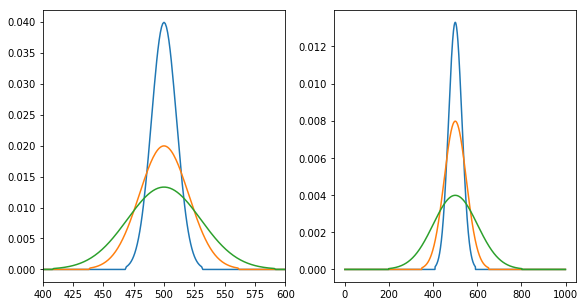

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
for sigma in [10,20,30]:
    y, x = kernel_smooth(one_spike, sigma, edges)
    plt.plot(x,y)
plt.xlim(400,600)

plt.subplot(1,4,2)
for sigma in [30,50,100]:
    y, x = kernel_smooth(one_spike, sigma, edges)
    plt.plot(x,y)



## Small sigma

In [9]:
label = 'DRRD 7'
spike_vector = select(io.load(label, 'epoched_spikes'),is_selected=True)
firing_rates = io.load(label, 'narrow_smoothed')

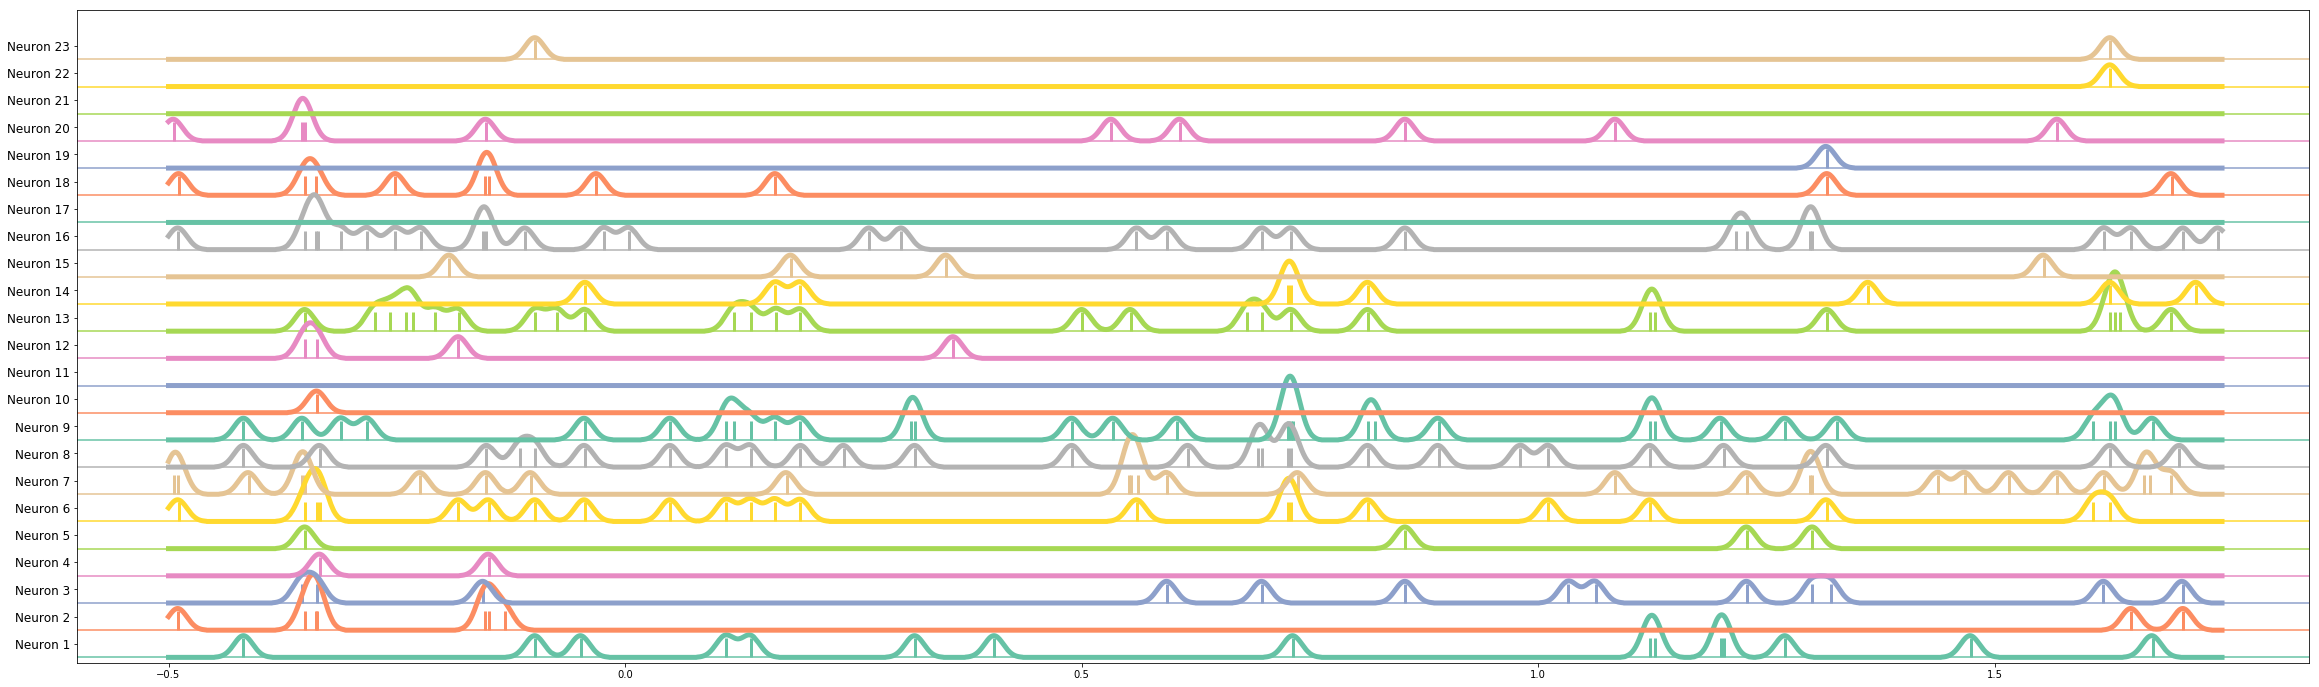

In [10]:
TRIAL = 130
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, 10, (-500,1750)))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values*20, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)});

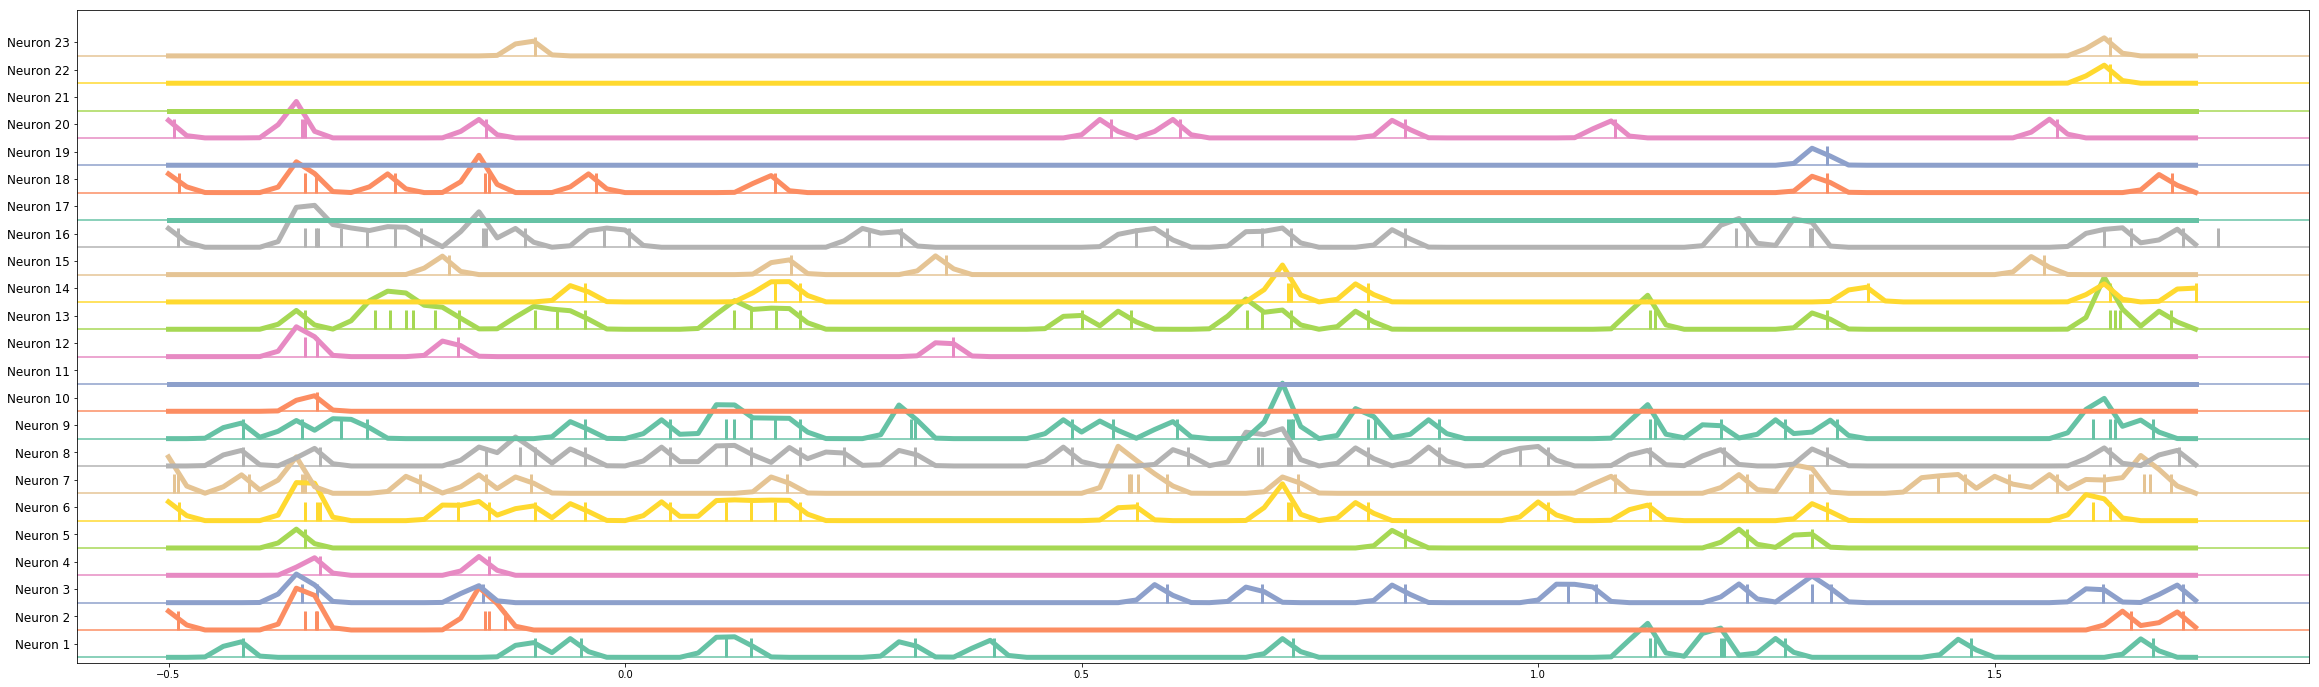

In [12]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 10, edges = (-500,1750), bin_size=20))
smk = pd.DataFrame(smk.tolist())

TRIAL = 130
pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)});

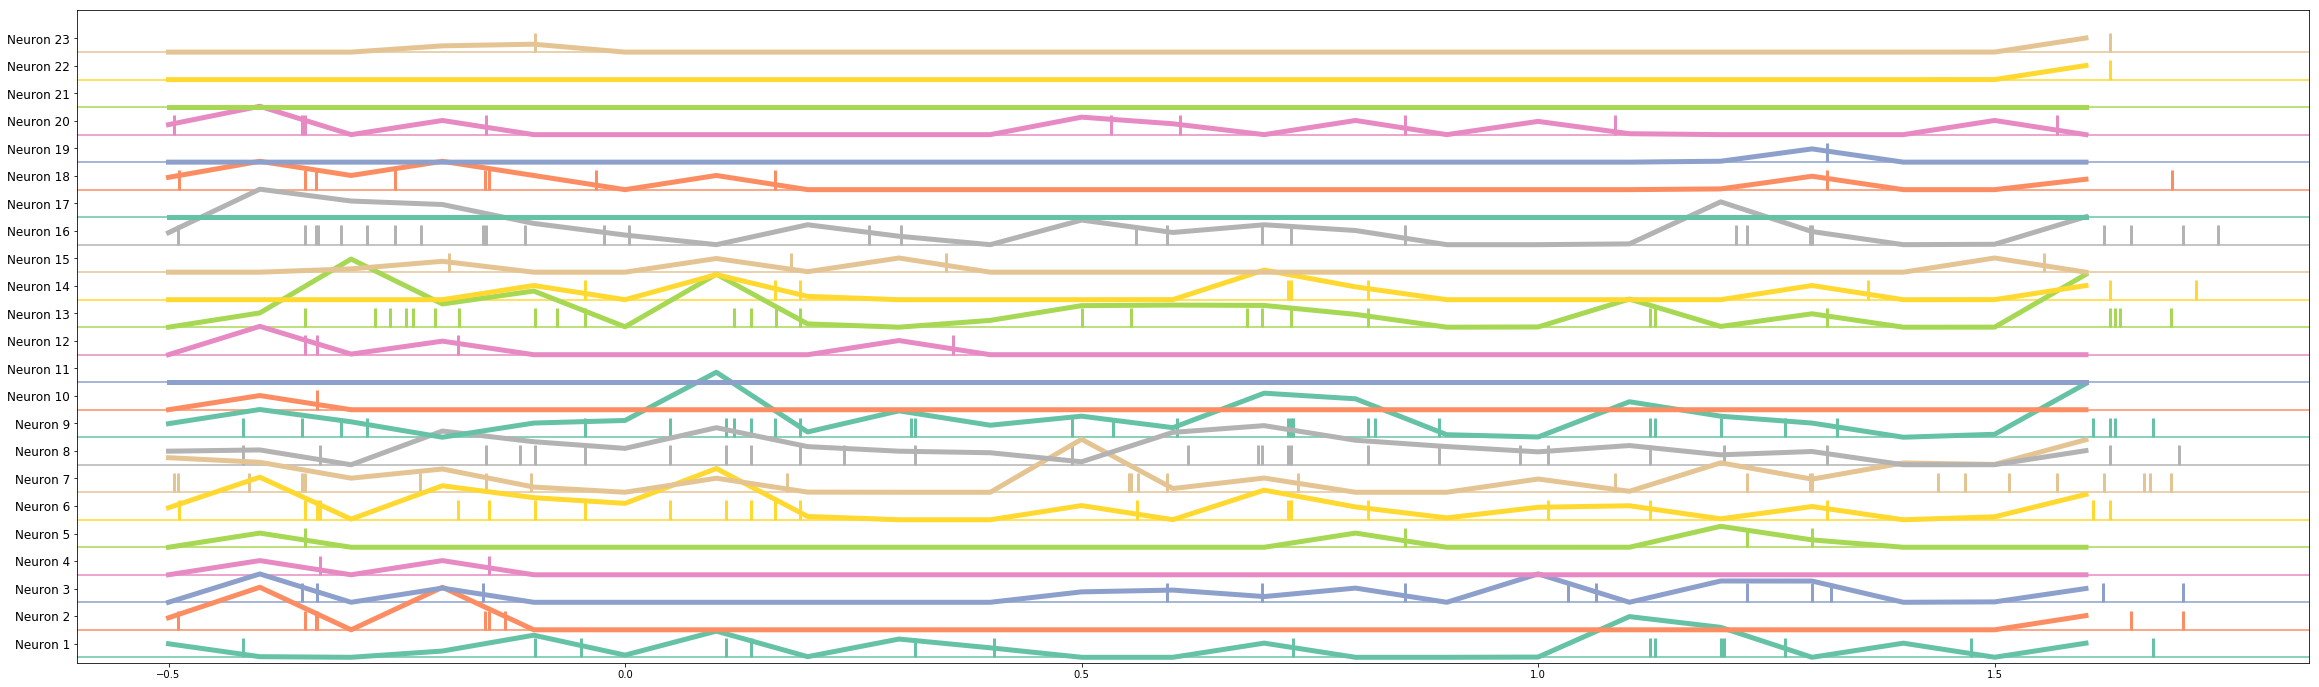

In [16]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 10, edges = (-500,1750), bin_size=100))
smk = pd.DataFrame(smk.tolist())

TRIAL = 130
pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)});

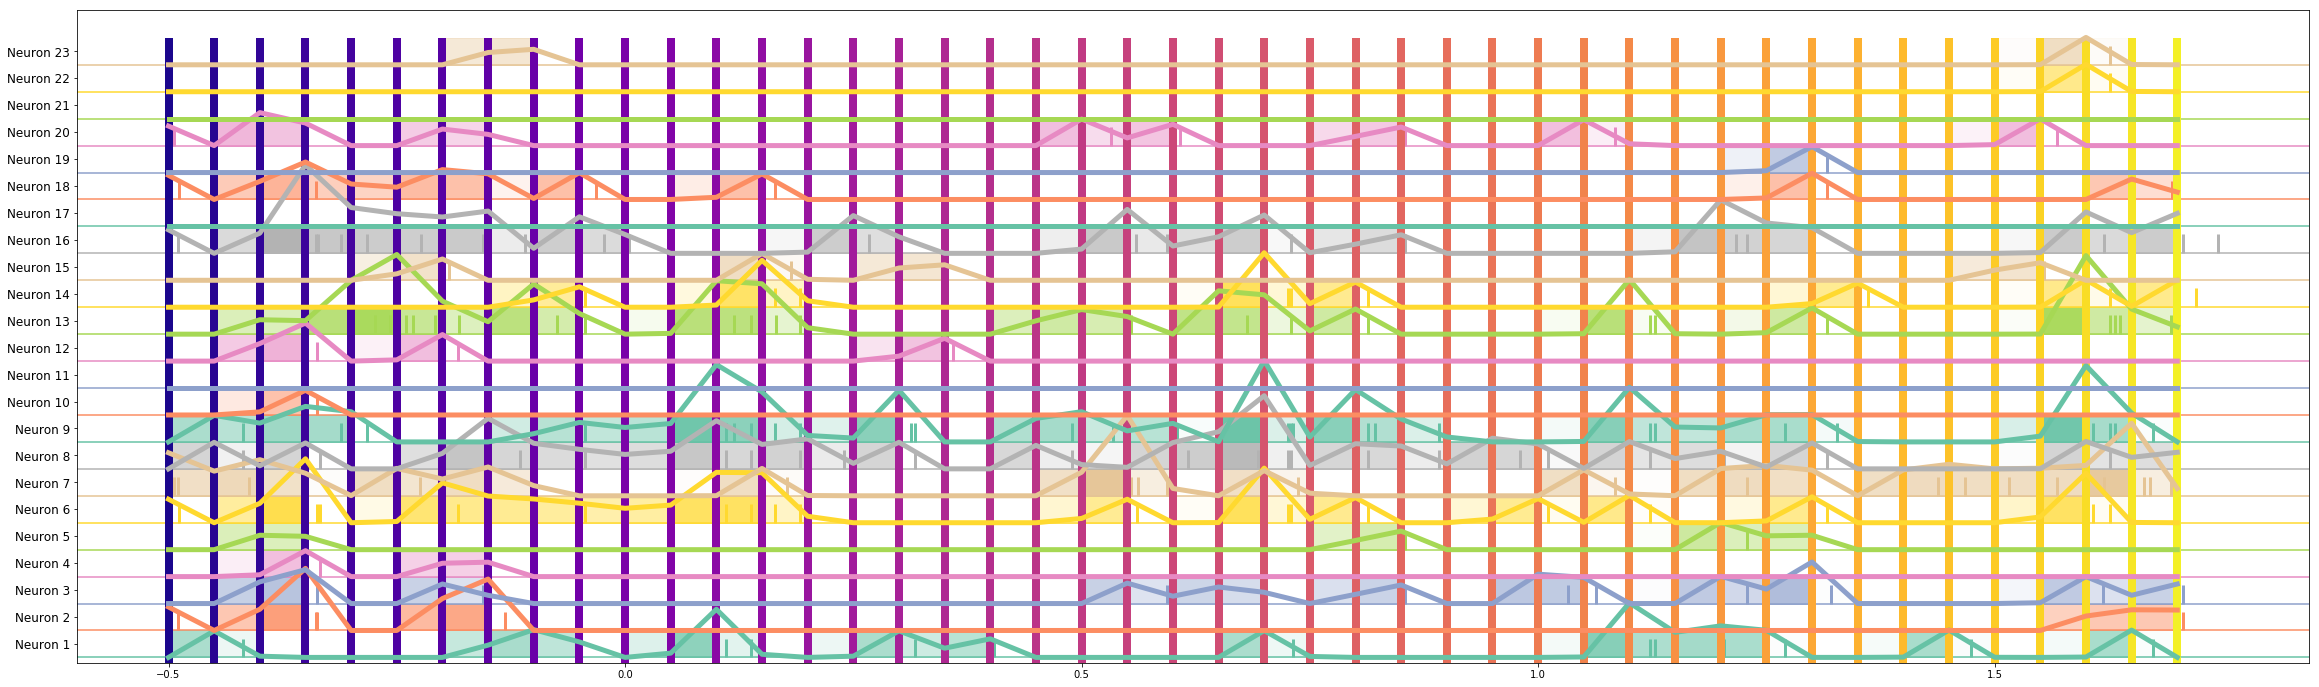

In [19]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 10, edges = (-500,1750), bin_size=50))
smk = pd.DataFrame(smk.tolist())

TRIAL = 130
pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=50, bin_fill=(23,44));

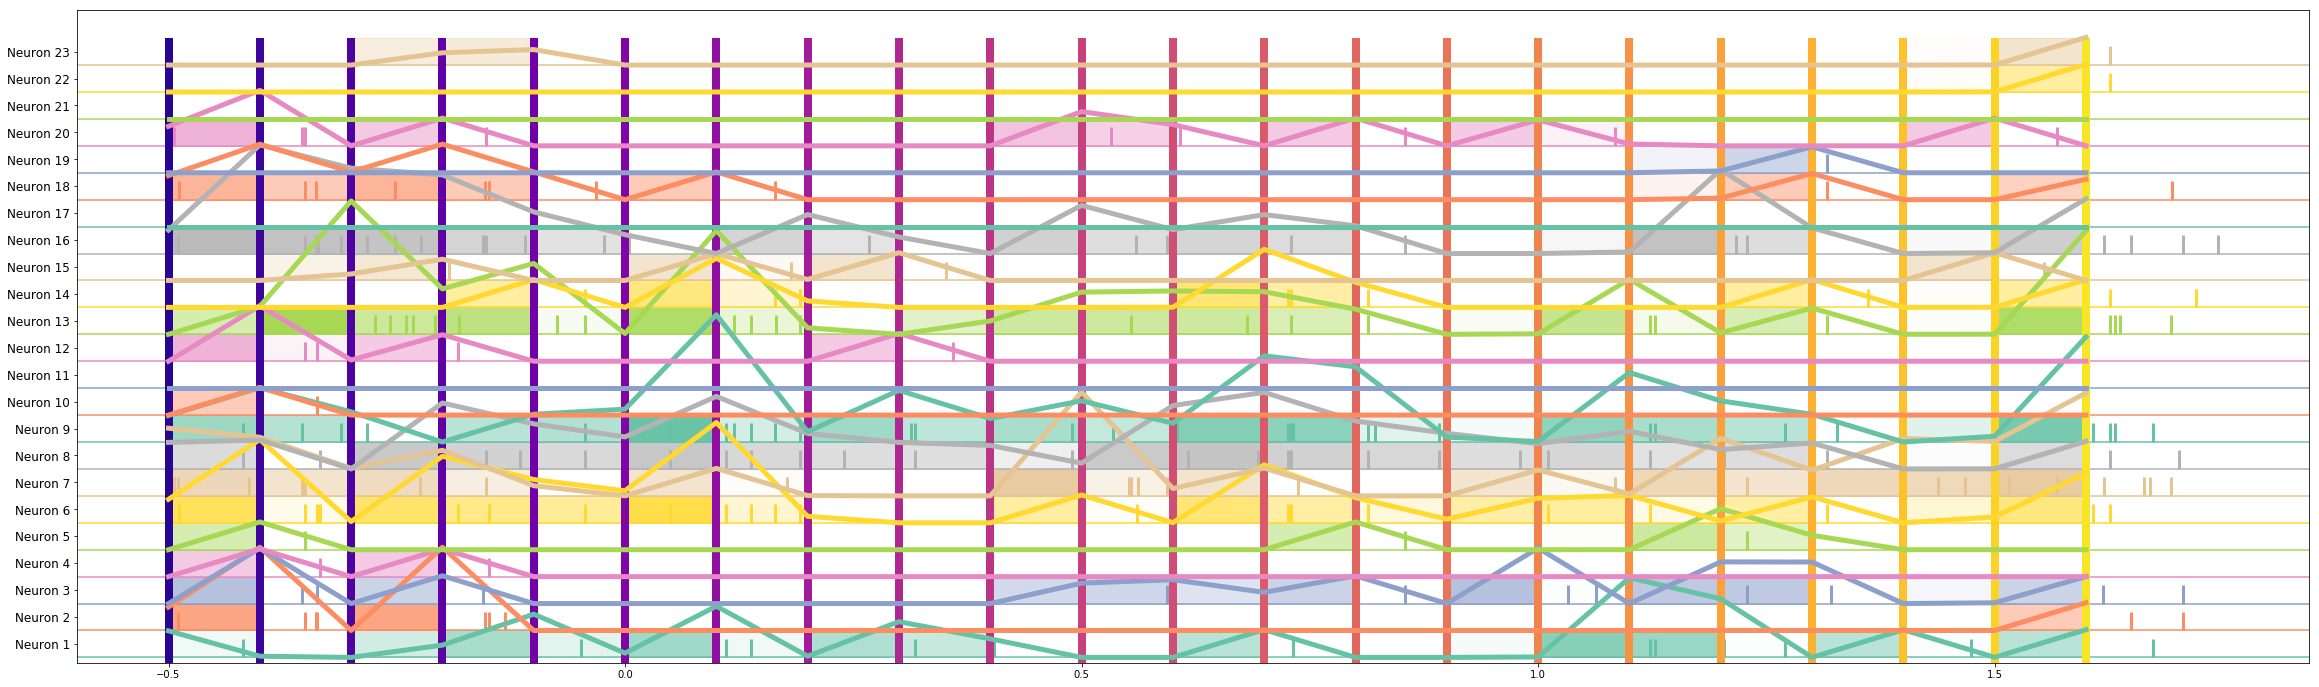

In [21]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 10, edges = (-500,1750), bin_size=100))
smk = pd.DataFrame(smk.tolist())

TRIAL = 130
pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=22, bin_fill=(23,21));

# Bigger sigma

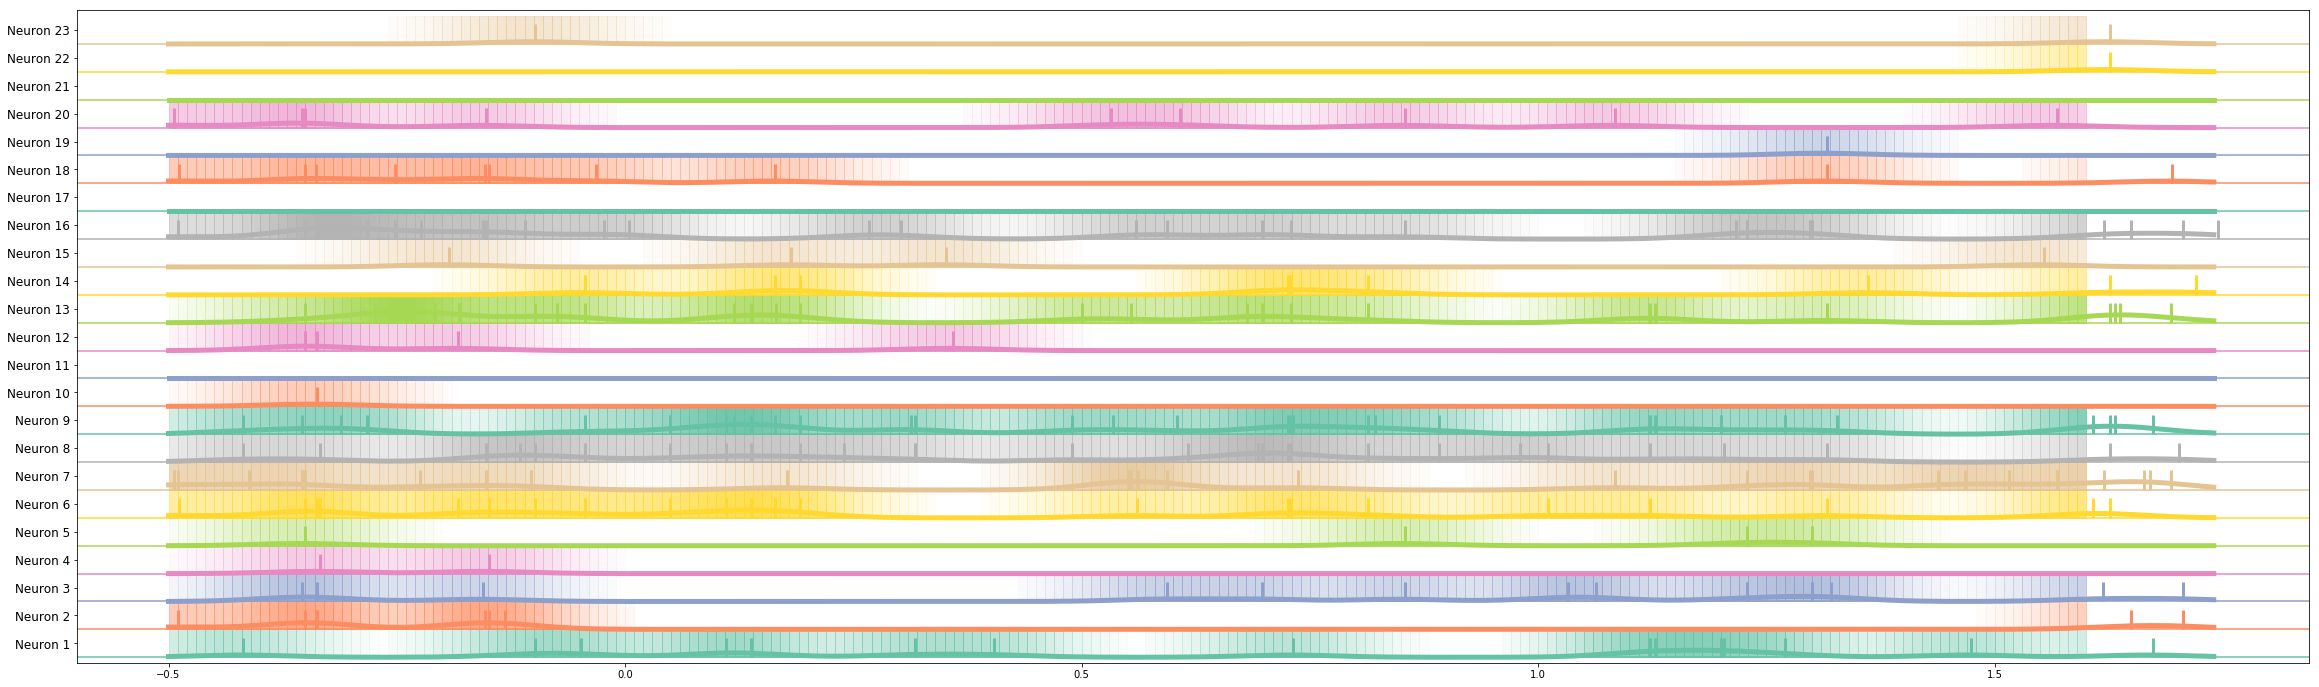

In [22]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 50, edges = (-500,1750), bin_size=10))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(23,210));

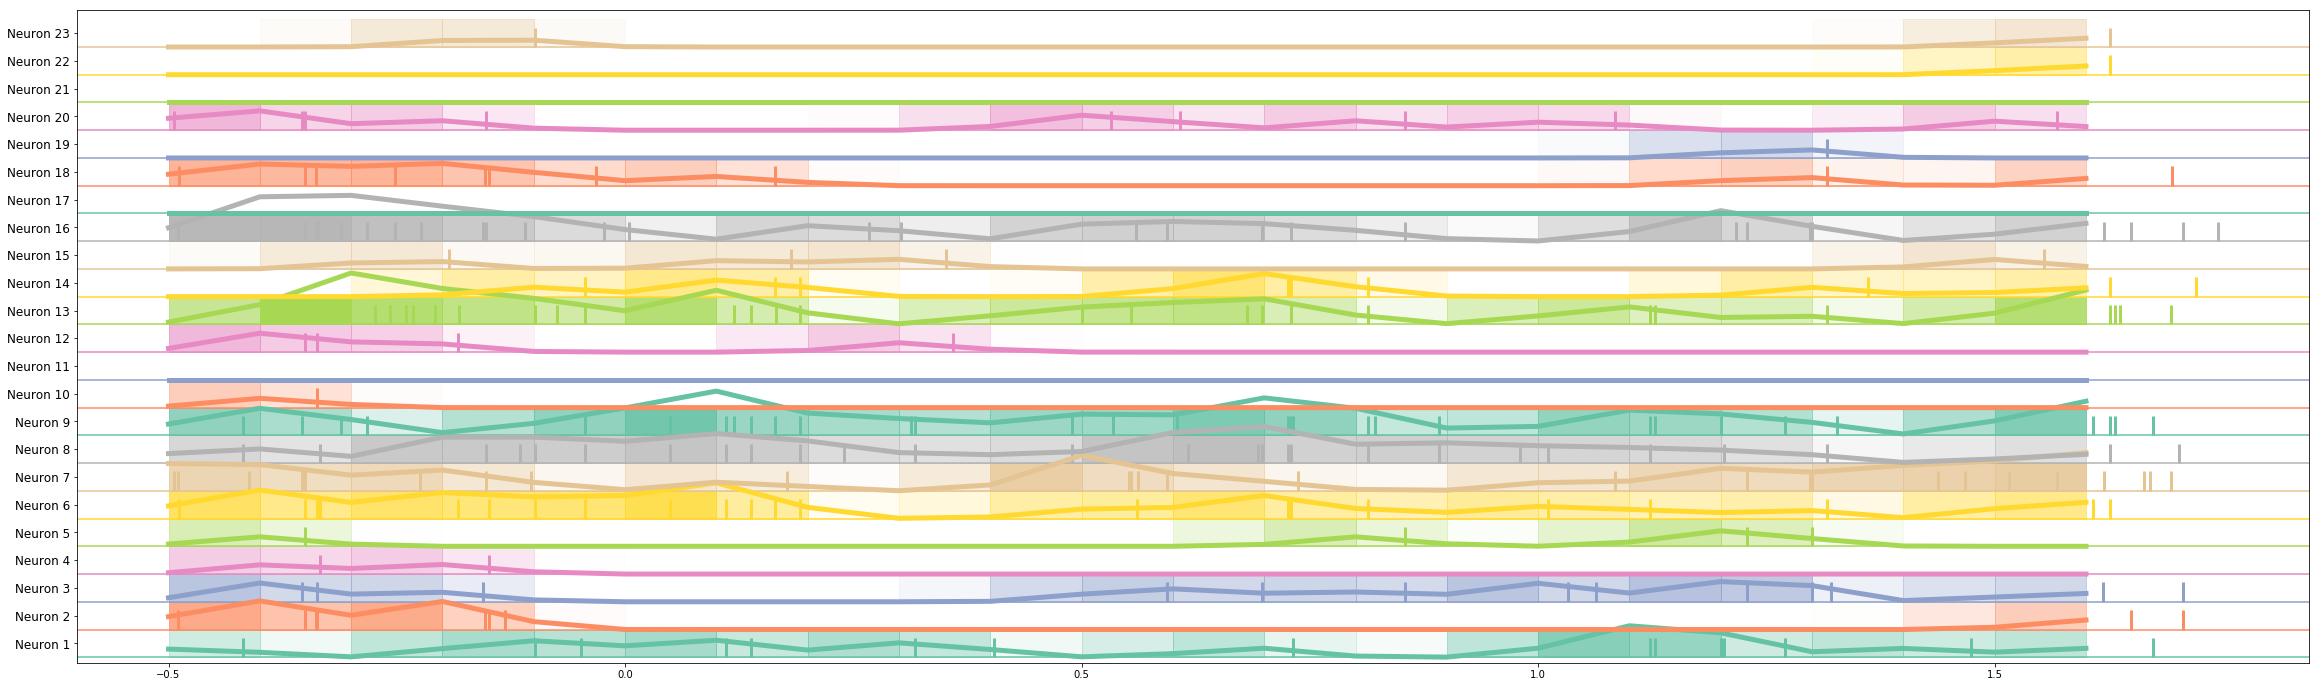

In [24]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 50, edges = (-500,1750), bin_size=100))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(23,21));

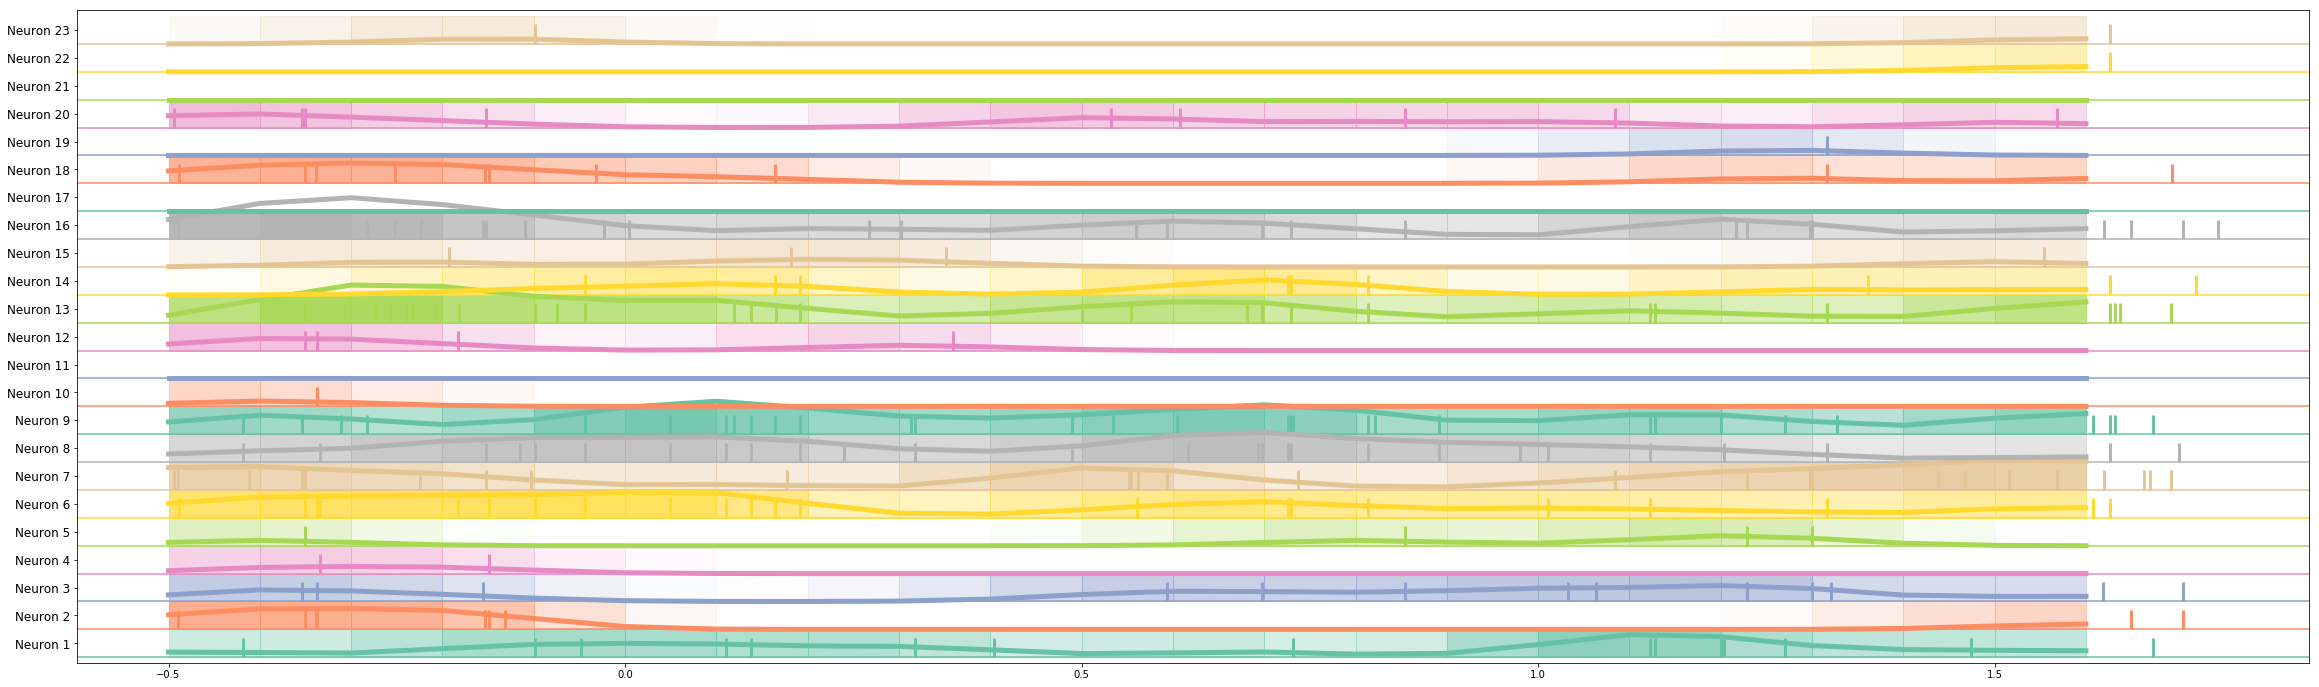

In [25]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 100, edges = (-500,1750), bin_size=100))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(23,21));

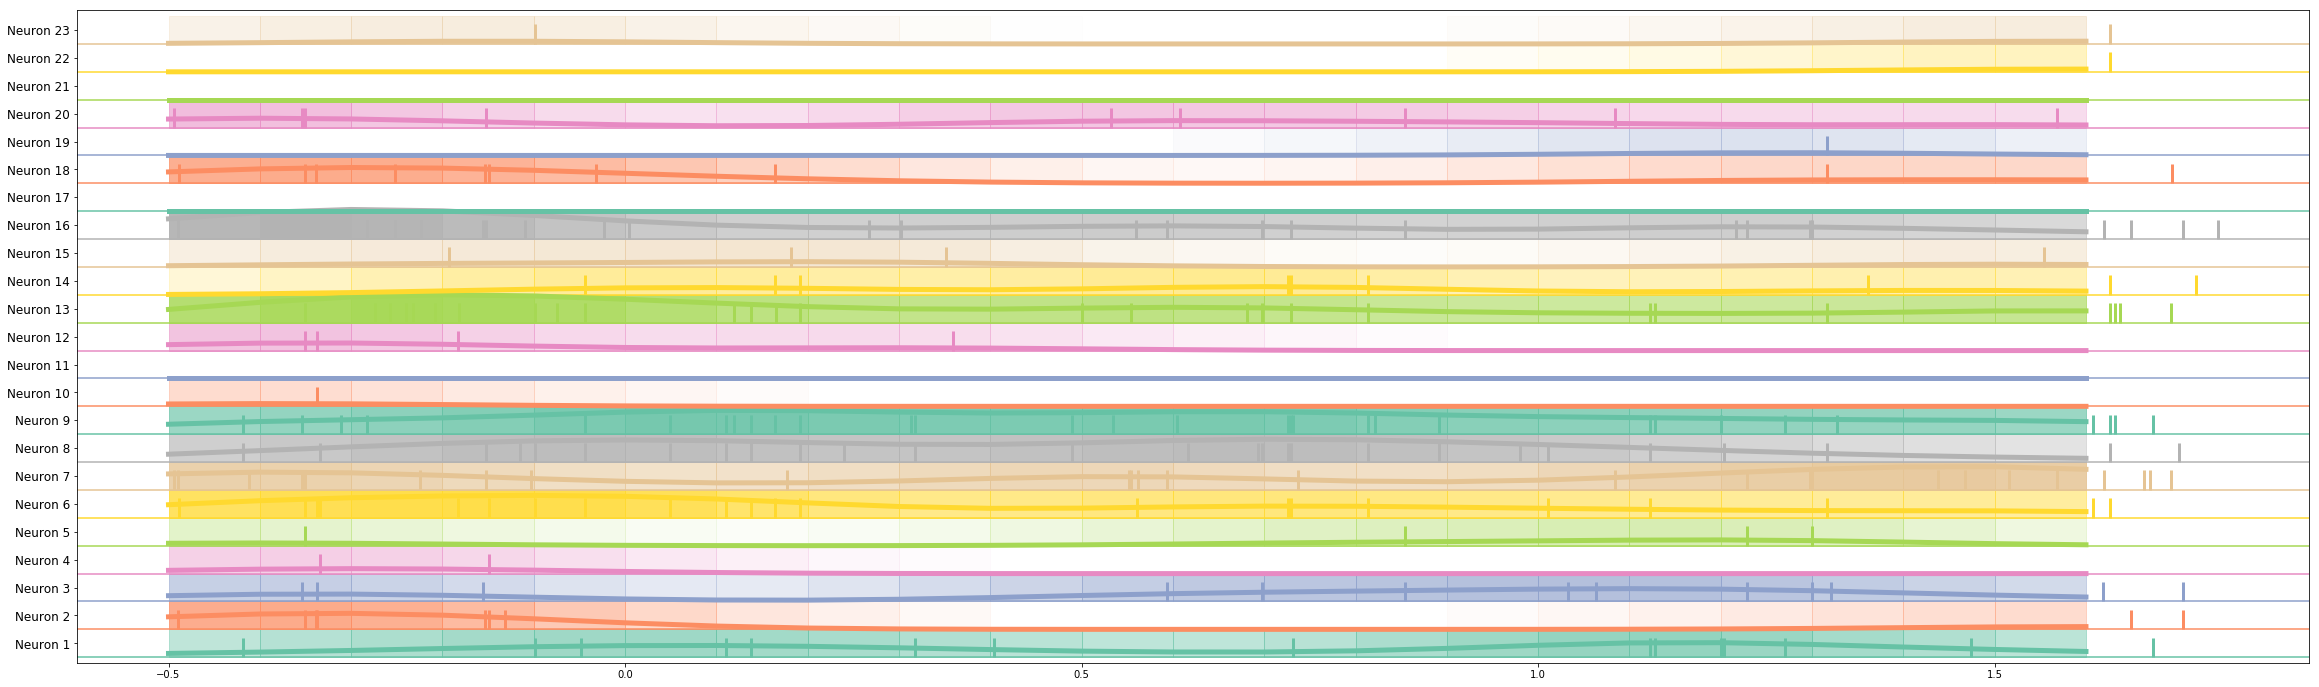

In [26]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 200, edges = (-500,1750), bin_size=100))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(23,21));

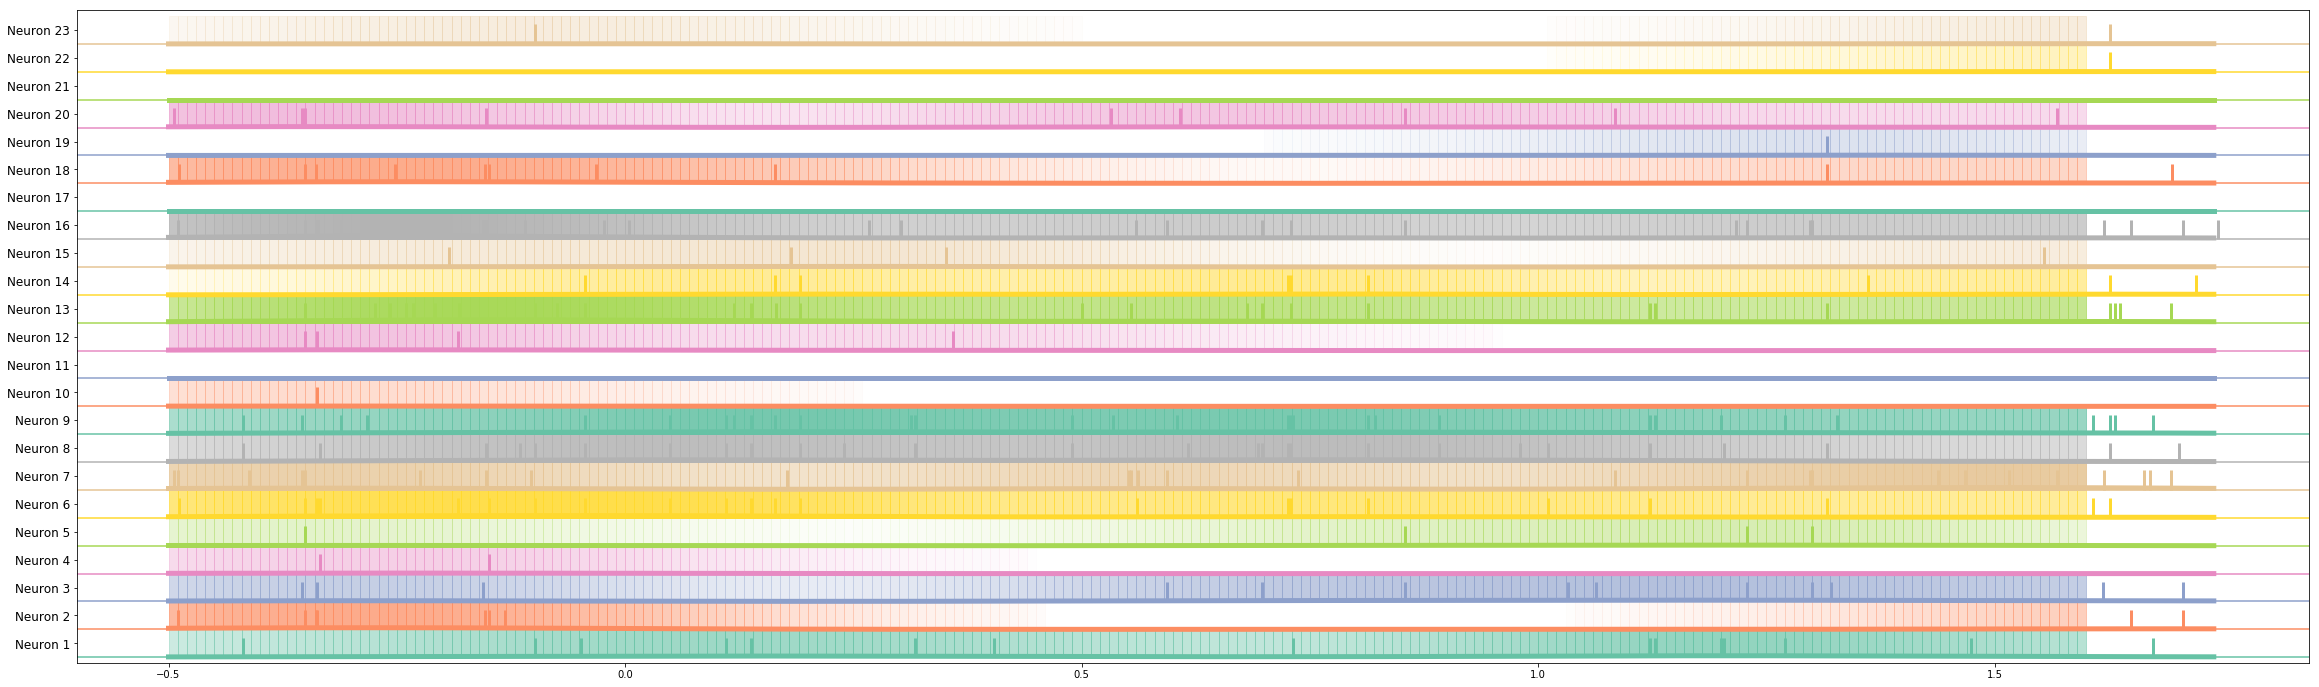

In [27]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 200, edges = (-500,1750), bin_size=10))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(23,210));

---

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.scatter()